In [3]:
import pandas as pd
import numpy as np
import datetime as dt
from scipy import sparse
from scipy.spatial.distance import cosine # cosine類似度に基づくcosine距離（類似していると数値が小さくなる）
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
df.max()

user_id            943
item_id           1682
rating               5
timestamp    893286638
dtype: int64

In [8]:
shape = (df.max().loc['user_id'], df.max().loc['item_id'])
R = np.zeros(shape)

for i in df.index:
    row = df.loc[i]
    R[row['user_id']-1, row['item_id']-1] = row['rating']

In [11]:
class CollaborativeFiltering:
    
    # 各ユーザごとの評価行列を受け取る
    def fit(self, rating_matrix):
        u_count = rating_matrix.shape[0]
        
        boolean_matrix = (rating_matrix > 0) * 1
        mean_ratings = [self.evaluated_mean(rating_matrix[i, :]) for i in range(u_count)]
        
        self.rating_matrix = rating_matrix
        self.rating_matrix_mean = (boolean_matrix.T * mean_ratings).T #各itemの評価のあるユーザのそれぞれの平均点
        
    def predict(self, x):
        sims = self.user_similarities(x) # 各ユーザとの類似度配列（１次元だよ）
        
        # 各ユーザとの類似度と評価行列について平均点を引いたものの内積により各itemの推定評価点が出る
        scores = sims.dot(self.rating_matrix - self.rating_matrix_mean)
        
        #類似度の内積（類似度の和）をnormとする
        norms = np.absolute(sims).dot((self.rating_matrix > 0) * 1)
        x_mean = self.evaluated_mean(x) # 比較対象ユーザの平均点
        
        p = scores / norms + x_mean
        
        for i in range(p.size):
            if np.isnan(p[i]):
                p[i] = 0.0
        
        return p
        
        
    def evaluated_mean(self, v):
        ev = v[v > 0]
        if ev.size > 0:
            return np.mean(ev)
        else:
            return 0
        
    def user_similarities(self, x):
        # n: user counts
        n = self.rating_matrix.shape[0]
        return np.array([self.similarity(x, self.rating_matrix[i]) for i in range(n)])
    
    def similarity(self, v1, v2):
        """
        v1: ユーザ１
        v2: ユーザ2
        return: v1とv2の類似度
        """
        idx = np.logical_and(v1 != 0, v2 != 0)
        
        v1_non_zero =  v1[idx]
        v2_non_zero =  v2[idx]
        
        sim = 0.0
        if v1_non_zero.size > 0:
            coef, _ = pearsonr(v1_non_zero, v2_non_zero) # pythonでは使わないタプルは_で受け取る
            if not np.isnan(coef):
                sim = coef
        
        return sim

In [25]:
# rating_matrix = R

# def evaluated_mean(v):
#     ev = v[v > 0]
#     if ev.size > 0:
#         return np.mean(ev)
#     else:
#         return 0

# u_count = rating_matrix.shape[0]
        
# boolean_matrix = (rating_matrix > 0) * 1
# mean_ratings = [evaluated_mean(rating_matrix[i, :]) for i in range(u_count)]
# rating_matrix_mean = (boolean_matrix.T * mean_ratings).T 

# rating_matrix_mean
# boolean_matrix.T
# # mean_ratings
# boolean_matrix.T * mean_ratings
# # boolean_matrix.T.dot(mean_ratings)

cf = CollaborativeFiltering()
cf.fit(R)

# matrixからユーザ0の評価列を取り出す
u = np.array(R.tolist()[0])
pred = cf.predict(u)

np.set_printoptions(threshold=np.inf) # notebookでの省略表記を解除
print(u)
print(pred)

[5. 3. 4. 3. 3. 5. 4. 1. 5. 3. 2. 5. 5. 5. 5. 5. 3. 4. 5. 4. 1. 4. 4. 3.
 4. 3. 2. 4. 1. 3. 3. 5. 4. 2. 1. 2. 2. 3. 4. 3. 2. 5. 4. 5. 5. 4. 4. 5.
 3. 5. 4. 4. 3. 3. 5. 4. 5. 4. 5. 5. 4. 3. 2. 5. 4. 4. 3. 4. 3. 3. 3. 4.
 3. 1. 4. 4. 4. 1. 4. 4. 5. 5. 3. 4. 3. 5. 5. 4. 5. 4. 5. 3. 5. 2. 4. 5.
 3. 4. 3. 5. 2. 2. 1. 1. 2. 4. 4. 5. 5. 1. 5. 1. 5. 5. 5. 3. 3. 3. 5. 1.
 4. 3. 4. 5. 3. 2. 5. 4. 5. 3. 1. 4. 4. 4. 4. 3. 5. 1. 3. 1. 3. 2. 1. 4.
 2. 4. 3. 2. 2. 5. 4. 5. 3. 5. 2. 4. 4. 3. 3. 4. 4. 4. 4. 3. 5. 5. 2. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 3. 3. 5. 4. 5. 4. 4. 4. 4. 3. 3. 5. 5. 4.
 4. 4. 5. 5. 5. 5. 4. 3. 3. 5. 4. 5. 3. 4. 5. 5. 4. 4. 3. 4. 2. 4. 3. 5.
 3. 3. 1. 3. 5. 4. 5. 5. 2. 3. 4. 5. 4. 4. 1. 3. 2. 4. 5. 4. 2. 4. 4. 3.
 4. 5. 1. 2. 2. 5. 1. 4. 4. 4. 4. 2. 5. 1. 2. 4. 4. 5. 1. 1. 1. 3. 1. 2.
 4. 1. 4. 5. 5. 5. 2. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

/Users/yamaji/study/python/py36/env/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/Users/yamaji/study/python/py36/env/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


numpy.ndarray

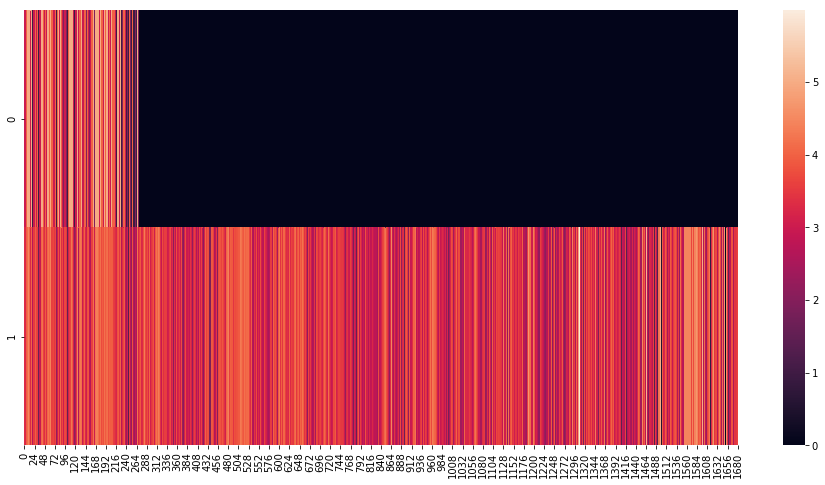

In [38]:
plt.figure(figsize=(16,8))
# sns.heatmap(u)
shape = u.shape
shape_item = shape[0]
shape_item

u = np.append(u, pred, axis=0).reshape((2, shape_item))
sns.heatmap(u)